# BERT Classification

In [122]:
import numpy as np
import pandas as pd

In [123]:
# import data cleaning libraries
import bs4 as bs
import nltk
import re

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize # tokenizes sentences
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bella\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bella\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [124]:
# import libraries for topic detection

# !pip install torch
# !pip install transformers
# !pip install vaderSentiment

# !pip install http://download.pytorch.org/whl/cu90/torch-0.4.1-cp36-cp36m-win_amd64.whl 
# !pip install torchvision

# !conda install pytorch torchvision cudatoolkit=10.2 -c pytorch

In [125]:
import os
import random
import glob

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import transformers
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import torch
from torch.utils.data import DataLoader

available_torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

False

# Metrics for the Classifier

In [ ]:
metrics = [
    'insurance', 
    'safety', 
    'balance', 
    'retirement', 
    'culture', 
    'racism', 
    'sexism', 
    'ageism', 
    'benefits', 
    'opportunities', 
    'privacy', 
    'resources']

print(len(metrics))

# Helper Methods

In [126]:
def glass_door_review_cleaner(reviews):
    """
    Cleans a review retrieved from the Glass Door scraper.
    
    Args:
        reviews::[pd.DataFrame]
            The table of given reviews and their statistics.
            
    Return:
       clean_reviews::[pd.DataFrame]
            The cleaned version of the reviews.
    """
    
    # drop any columns, if needed
    clean_reviews = reviews.drop([], axis = 1)
    
    # remove newline characters
    clean_reviews['pros'] = clean_reviews['pros'].str.replace('\n', '', regex = True)
    clean_reviews['cons'] = clean_reviews['cons'].str.replace('\n', '', regex = True)
    
    # remove carriage returns
    clean_reviews['pros'] = clean_reviews['pros'].str.replace('\r', '', regex = True)
    clean_reviews['cons'] = clean_reviews['cons'].str.replace('\r', '', regex = True)

    # remove bad strings caught by the web scraper
    badString1 = "Verify your email to continue reading or Resend email"
    badString2 = "Be the first to find this review helpfulHelpfulShareRepor"

    clean_reviews['cons'] = clean_reviews['cons'].str.replace(badString1, '', regex = True)
    clean_reviews['cons'] = clean_reviews['cons'].str.replace(badString2, '', regex = True)

    # compile pros and cons together into a column
    clean_reviews['text'] = "{ Pros. " + clean_reviews['pros'] + " } { Cons. " + clean_reviews['cons'] + " }"

    # remove empty reviews
    clean_reviews = clean_reviews.dropna(subset = ['text'])
    clean_reviews = clean_reviews.reset_index(drop = True)
    
    return clean_reviews

In [127]:
def final_review_cleaner(reviews, lemmatize = True, stem = False):
    """
    Clean and preprocess a review.

    Args:
        reviews::[pd.DataFrame]
            The table of given reviews and their statistics.
        lemmatize::[boolean]
            A flag for feature lemmatization.
        stem::[boolean]
            A flag for feature stemming.
            
    Return:
        cleaned_reviews::[pd.DataFrame]
            The cleaned version of the reviews.
    """
    
    ps = PorterStemmer()
    wnl = WordNetLemmatizer()
    
    #1. Remove HTML tags
    cleaned_reviews=[]
    for i,review in enumerate(reviews['text']):
    # print progress
        if (i + 1) % 500 == 0:
            print("Done with %d reviews" %(i+1))
        review = bs.BeautifulSoup(review).text

        #2. Use regex to find emoticons
        emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', review)

        #3. Remove punctuation
        review = re.sub("[^a-zA-Z]", " ", review)

        #4. Tokenize into words (all lower case)
        review = review.lower().split()

        #5. Remove stopwords
        eng_stopwords = set(stopwords.words("english"))
            
        clean_review = []
        for word in review:
            if word not in eng_stopwords:
                if lemmatize is True:
                    word = wnl.lemmatize(word)
                elif stem is True:
                    if word == 'oed':
                        continue
                    word = ps.stem(word)
                clean_review.append(word)

        #6. Join the review to one sentence
        review_processed = ' '.join(clean_review + emoticons)
        cleaned_reviews.append(review_processed)
    
    return cleaned_reviews

In [128]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def round_two_digit_string(x):
    """
    Rounds a float to two decimal places.
    
    Args:
        x::[float]
            The float number to round.
            
    Return:
            The rounded float.
    """
    return str(round(x, 2))

def retrieve_sentiment_analysis(df, column):
    """ Performs a sentiment analysis on the given data.
    
    Args:
        df::[pd.DataFrame]
            The table of given reviews and their statistics.
            
    Return:
        sentiment_df::[pd.DataFrame]
            The reviews with their sentiment analysis data.
    """
    
    analyzer = SentimentIntensityAnalyzer()
    data = {
        "text": [],
        "negative": [],
        "neutral": [],
        "positive": [],
        "compound": []
    }

    for sentence in df[column]:
        vs = analyzer.polarity_scores(sentence)

        data["text"].append(sentence)
        data["negative"].append(round_two_digit_string(vs["neg"]))
        data["neutral"].append(round_two_digit_string(vs["neu"]))
        data["positive"].append(round_two_digit_string(vs["pos"]))
        data["compound"].append(round_two_digit_string(vs["compound"]))
        
    sentiment_df = pd.DataFrame(data)
    
    return sentiment_df

In [ ]:
class MYDataset(torch.utils.data.Dataset):
    """ A Dataset class for PyTorch data loading. """
    
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Training The Model

In [11]:
# STEP 1 - OPEN CLASSIFIER DATASET [currently set to classify pros]
# train = pd.read_csv("train_old.csv", header = 0, sep = ",")
train = pd.read_csv("train.csv", header = 0, sep = ",")
train.head()

,ID,Initial_ID,text,insurance,safety,balance,retirement,culture,racism,sexism,ageism,benefits,opportunities,privacy,resources
0,5145.0,743.0,Work life balance,0,0,1,0,0,0,0,0,0,0,0,0
1,5134.0,732.0,Many opportunities off program to explore diff...,0,0,0,0,0,0,0,0,0,1,0,0
2,5132.0,730.0,Flexible Leadership is strong Challenging Lear...,0,0,1,0,0,0,0,0,0,1,0,0
3,5126.0,724.0,Collaborative culture,0,0,0,0,1,0,0,0,0,0,0,0
4,5123.0,721.0,Culture Work ethics technology quality experts.,0,0,0,0,1,0,0,0,0,0,0,0


In [12]:
train.shape

(2004, 15)

In [13]:
# drop useless data
# train = train.drop(["Unnamed: 0", "ID", "Initial_ID", "S"], axis = 1)
train = train.drop(["ID", "Initial_ID"], axis = 1)
train = train.dropna()

train.head()

,text,insurance,safety,balance,retirement,culture,racism,sexism,ageism,benefits,opportunities,privacy,resources
0,Work life balance,0,0,1,0,0,0,0,0,0,0,0,0
1,Many opportunities off program to explore diff...,0,0,0,0,0,0,0,0,0,1,0,0
2,Flexible Leadership is strong Challenging Lear...,0,0,1,0,0,0,0,0,0,1,0,0
3,Collaborative culture,0,0,0,0,1,0,0,0,0,0,0,0
4,Culture Work ethics technology quality experts.,0,0,0,0,1,0,0,0,0,0,0,0


In [14]:
train.shape

(2004, 13)

In [15]:
# review the dataset
for metric in metrics:
    uvc = train[metric].value_counts(sort = True, ascending = False)
    print(f'{uvc}\n')

0    1907
1      97
Name: insurance, dtype: int64

0    1919
1      85
Name: safety, dtype: int64

0    1646
1     358
Name: balance, dtype: int64

0    1965
1      39
Name: retirement, dtype: int64

0    1625
1     379
Name: culture, dtype: int64

0    1984
1      20
Name: racism, dtype: int64

0    1989
1      15
Name: sexism, dtype: int64

0    1992
1      12
Name: ageism, dtype: int64

0    1380
1     624
Name: benefits, dtype: int64

0    1643
1     361
Name: opportunities, dtype: int64

0    2000
1       4
Name: privacy, dtype: int64

0    1909
1      95
Name: resources, dtype: int64



In [81]:
TRAIN_BATCH_SIZE = int(input("How big would you like your batch size to be?: "))
EVAL_BATCH_SIZE = TRAIN_BATCH_SIZE + 20
TEST_PORTION = 0.2
print(f'Batch size will then be {EVAL_BATCH_SIZE} and the testing size will be {TEST_PORTION * 100}%.')

print(f'\nMetric List: {metrics}')
CURRENT_METRIC = input(f'Which of the {len(metrics)} metrics would you like to focus on currently?: ')

How big would you like your batch size to be?: 40
Batch size will then be 60 and the testing size will be 20.0%.

Metric List: ['insurance', 'safety', 'balance', 'retirement', 'culture', 'racism', 'sexism', 'ageism', 'benefits', 'opportunities', 'privacy', 'resources']
Which of the 12 metrics would you like to focus on currently?: resources


In [17]:
# STEP 2 - TOKENIZE INPUT AND CREATE TRAINING/TESTING SETS
Xtrain_insurance, Xval_insurance = train_test_split(train[['text', 'insurance']], random_state = 0, test_size = TEST_PORTION)
Xtrain_safety, Xval_safety = train_test_split(train[['text', 'safety']], random_state = 0, test_size = TEST_PORTION) 
Xtrain_balance, Xval_balance = train_test_split(train[['text', 'balance']], random_state = 0, test_size = TEST_PORTION)
Xtrain_retirement, Xval_retirement = train_test_split(train[['text', 'retirement']], random_state = 0, test_size = TEST_PORTION) 
Xtrain_culture, Xval_culture = train_test_split(train[['text', 'culture']], random_state = 0, test_size = TEST_PORTION)
Xtrain_racism, Xval_racism = train_test_split(train[['text', 'racism']], random_state = 0, test_size = TEST_PORTION) 
Xtrain_sexism, Xval_sexism = train_test_split(train[['text', 'sexism']], random_state = 0, test_size = TEST_PORTION) 
Xtrain_ageism, Xval_ageism = train_test_split(train[['text', 'ageism']], random_state = 0, test_size = TEST_PORTION) 
Xtrain_benefits, Xval_benefits = train_test_split(train[['text', 'benefits']], random_state = 0, test_size = TEST_PORTION) 
Xtrain_opportunities, Xval_opportunities = train_test_split(train[['text', 'opportunities']], random_state = 0, test_size = TEST_PORTION) 
Xtrain_privacy, Xval_privacy = train_test_split(train[['text', 'privacy']], random_state = 0, test_size = TEST_PORTION)
Xtrain_resources, Xval_resources = train_test_split(train[['text', 'resources']], random_state = 0, test_size = TEST_PORTION)

Xtrains = {
    'insurance': Xtrain_insurance,
    'safety': Xtrain_safety,
    'balance': Xtrain_balance,
    'retirement': Xtrain_retirement,
    'culture': Xtrain_culture,
    'racism': Xtrain_racism,
    'sexism': Xtrain_sexism,
    'ageism': Xtrain_ageism,
    'benefits': Xtrain_benefits,
    'opportunities': Xtrain_opportunities,
    'privacy': Xtrain_privacy,
    'resources': Xtrain_resources
}

Xvals = {
    'insurance': Xval_insurance,
    'safety': Xval_safety,
    'balance': Xval_balance,
    'retirement': Xval_retirement,
    'culture': Xval_culture,
    'racism': Xval_racism,
    'sexism': Xval_sexism,
    'ageism': Xval_ageism,
    'benefits': Xval_benefits,
    'opportunities': Xval_opportunities,
    'privacy': Xval_privacy,
    'resources': Xval_resources
}

(1603, 2) (401, 2)


In [18]:
# For BERT model, the text inputs must be converted to tokens with tokenizer
# Here we use a distiled version of BERT base model (DistilBERT) for fast prototyping
# https://huggingface.co/distilbert-base-cased 
# The tokenizer to use is the pretrained DistilBERT tokenizer
# https://huggingface.co/transformers/model_doc/distilbert.html#transformers.DistilBertTokenizer
# Feel free to try on different pretrained BERT model for your own applications but please remember to match the tokenizer with
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# with the selected tokenizer, prepare the inputs and labels with correct datatype for each label
tokenized_train_insurance = tokenizer(Xtrain_insurance['text'].tolist(), padding = "max_length", truncation = True)
tokenized_val_insurance = tokenizer(Xval_insurance['text'].tolist(), padding = "max_length", truncation = True)
train_labels_insurance = Xtrain_insurance['insurance'].tolist()
val_labels_insurance = Xval_insurance['insurance'].tolist()

tokenized_train_safety = tokenizer(Xtrain_safety['text'].tolist(), padding = "max_length", truncation = True)
tokenized_val_safety = tokenizer(Xval_safety['text'].tolist(), padding = "max_length", truncation = True)
train_labels_safety = Xtrain_safety['safety'].tolist()
val_labels_safety = Xval_safety['safety'].tolist()

tokenized_train_balance = tokenizer(Xtrain_balance['text'].tolist(), padding = "max_length", truncation = True)
tokenized_val_balance = tokenizer(Xval_balance['text'].tolist(), padding = "max_length", truncation = True)
train_labels_balance = Xtrain_balance['balance'].tolist()
val_labels_balance = Xval_balance['balance'].tolist()

tokenized_train_retirement = tokenizer(Xtrain_retirement['text'].tolist(), padding = "max_length", truncation = True) 
tokenized_val_retirement = tokenizer(Xval_retirement['text'].tolist(), padding = "max_length", truncation = True)
train_labels_retirement = Xtrain_retirement['retirement'].tolist()
val_labels_retirement = Xval_retirement['retirement'].tolist()

tokenized_train_culture = tokenizer(Xtrain_culture['text'].tolist(), padding = "max_length", truncation = True)
tokenized_val_culture = tokenizer(Xval_culture['text'].tolist(), padding = "max_length", truncation = True)
train_labels_culture = Xtrain_culture['culture'].tolist()
val_labels_culture = Xval_culture['culture'].tolist()

tokenized_train_racism = tokenizer(Xtrain_racism['text'].tolist(), padding = "max_length", truncation = True)
tokenized_val_racism = tokenizer(Xval_racism['text'].tolist(), padding = "max_length", truncation = True)
train_labels_racism = Xtrain_racism['racism'].tolist()
val_labels_racism = Xval_racism['racism'].tolist()

tokenized_train_sexism = tokenizer(Xtrain_sexism['text'].tolist(), padding = "max_length", truncation = True)
tokenized_val_sexism = tokenizer(Xval_sexism['text'].tolist(), padding = "max_length", truncation = True)
train_labels_sexism = Xtrain_sexism['sexism'].tolist()
val_labels_sexism = Xval_sexism['sexism'].tolist()

tokenized_train_ageism = tokenizer(Xtrain_ageism['text'].tolist(), padding = "max_length", truncation = True) 
tokenized_val_ageism = tokenizer(Xval_ageism['text'].tolist(), padding = "max_length", truncation = True)
train_labels_ageism = Xtrain_ageism['ageism'].tolist()
val_labels_ageism = Xval_ageism['ageism'].tolist()

tokenized_train_benefits = tokenizer(Xtrain_benefits['text'].tolist(), padding = "max_length", truncation = True) 
tokenized_val_benefits = tokenizer(Xval_benefits['text'].tolist(), padding = "max_length", truncation = True)
train_labels_benefits = Xtrain_benefits['benefits'].tolist()
val_labels_benefits = Xval_benefits['benefits'].tolist()

tokenized_train_opportunities = tokenizer(Xtrain_opportunities['text'].tolist(), padding = "max_length", truncation = True) 
tokenized_val_opportunities = tokenizer(Xval_opportunities['text'].tolist(), padding = "max_length", truncation = True)
train_labels_opportunities = Xtrain_opportunities['opportunities'].tolist()
val_labels_opportunities = Xval_opportunities['opportunities'].tolist()

tokenized_train_privacy = tokenizer(Xtrain_privacy['text'].tolist(), padding = "max_length", truncation = True) 
tokenized_val_privacy = tokenizer(Xval_privacy['text'].tolist(), padding = "max_length", truncation = True)
train_labels_privacy = Xtrain_privacy['privacy'].tolist()
val_labels_privacy = Xval_privacy['privacy'].tolist()

tokenized_train_resources = tokenizer(Xtrain_resources['text'].tolist(), padding = "max_length", truncation = True) 
tokenized_val_resources = tokenizer(Xval_resources['text'].tolist(), padding = "max_length", truncation = True)
train_labels_resources = Xtrain_resources['resources'].tolist()
val_labels_resources = Xval_resources['resources'].tolist()

In [19]:
# implement the tokenized inputs and labels into PyTorch datasets
train_dataset_insurance = MYDataset(tokenized_train_insurance, train_labels_insurance)
val_dataset_insurance = MYDataset(tokenized_val_insurance, val_labels_insurance)
train_loader_insurance = DataLoader(train_dataset_insurance, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_insurance = DataLoader(val_dataset_insurance, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_safety = MYDataset(tokenized_train_safety, train_labels_safety)
val_dataset_safety = MYDataset(tokenized_val_safety, val_labels_safety)
train_loader_safety = DataLoader(train_dataset_safety, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_safety = DataLoader(val_dataset_safety, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_balance = MYDataset(tokenized_train_balance, train_labels_balance)
val_dataset_balance = MYDataset(tokenized_val_balance, val_labels_balance)
train_loader_balance = DataLoader(train_dataset_balance, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_balance = DataLoader(val_dataset_balance, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_retirement = MYDataset(tokenized_train_retirement, train_labels_retirement)
val_dataset_retirement = MYDataset(tokenized_val_retirement, val_labels_retirement)
train_loader_retirement = DataLoader(train_dataset_retirement, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_retirement = DataLoader(val_dataset_retirement, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_culture = MYDataset(tokenized_train_culture, train_labels_culture)
val_dataset_culture = MYDataset(tokenized_val_culture, val_labels_culture)
train_loader_culture = DataLoader(train_dataset_culture, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_culture = DataLoader(val_dataset_culture, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_racism = MYDataset(tokenized_train_racism, train_labels_racism)
val_dataset_racism = MYDataset(tokenized_val_racism, val_labels_racism)
train_loader_racism = DataLoader(train_dataset_racism, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_racism = DataLoader(val_dataset_racism, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_sexism = MYDataset(tokenized_train_sexism, train_labels_sexism)
val_dataset_sexism = MYDataset(tokenized_val_sexism, val_labels_sexism)
train_loader_sexism = DataLoader(train_dataset_sexism, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_sexism = DataLoader(val_dataset_sexism, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_ageism = MYDataset(tokenized_train_ageism, train_labels_ageism)
val_dataset_ageism = MYDataset(tokenized_val_ageism, val_labels_ageism)
train_loader_ageism = DataLoader(train_dataset_ageism, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_ageism = DataLoader(val_dataset_ageism, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_benefits = MYDataset(tokenized_train_benefits, train_labels_benefits)
val_dataset_benefits = MYDataset(tokenized_val_benefits, val_labels_benefits)
train_loader_benefits = DataLoader(train_dataset_benefits, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_benefits = DataLoader(val_dataset_benefits, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_opportunities = MYDataset(tokenized_train_opportunities, train_labels_opportunities)
val_dataset_opportunities = MYDataset(tokenized_val_opportunities, val_labels_opportunities)
train_loader_opportunities = DataLoader(train_dataset_opportunities, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_opportunities = DataLoader(val_dataset_opportunities, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_privacy = MYDataset(tokenized_train_privacy, train_labels_privacy)
val_dataset_privacy = MYDataset(tokenized_val_privacy, val_labels_privacy)
train_loader_privacy = DataLoader(train_dataset_privacy, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_privacy = DataLoader(val_dataset_privacy, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

train_dataset_resources = MYDataset(tokenized_train_resources, train_labels_resources)
val_dataset_resources = MYDataset(tokenized_val_resources, val_labels_resources)
train_loader_resources = DataLoader(train_dataset_resources, batch_size = TRAIN_BATCH_SIZE, shuffle = False)
val_loader_resources = DataLoader(val_dataset_resources, batch_size = TRAIN_BATCH_SIZE, shuffle = False)

In [ ]:
# put all of the data into a dictionary to be able to access it all
train_datasets = {
    'insurance': train_dataset_insurance,
    'safety': train_dataset_safety,
    'balance': train_dataset_balance,
    'retirement': train_dataset_retirement,
    'culture': train_dataset_culture,
    'racism': train_dataset_racism,
    'sexism': train_dataset_sexism,
    'ageism': train_dataset_ageism,
    'benefits': train_dataset_benefits,
    'opportunities': train_dataset_opportunities,
    'privacy': train_dataset_privacy,
    'resources': train_dataset_resources
}

train_loaders = {
    'insurance': train_loader_insurance,
    'safety': train_loader_safety,
    'balance': train_loader_balance,
    'retirement': train_loader_retirement,
    'culture': train_loader_culture,
    'racism': train_loader_racism,
    'sexism': train_loader_sexism,
    'ageism': train_loader_ageism,
    'benefits': train_loader_benefits,
    'opportunities': train_loader_opportunities,
    'privacy': train_loader_privacy,
    'resources': train_loader_resources
}

val_datasets = {
    'insurance': val_dataset_insurance,
    'safety': val_dataset_safety,
    'balance': val_dataset_balance,
    'retirement': val_dataset_retirement,
    'culture': val_dataset_culture,
    'racism': val_dataset_racism,
    'sexism': val_dataset_sexism,
    'ageism': val_dataset_ageism,
    'benefits': val_dataset_benefits,
    'opportunities': val_dataset_opportunities,
    'privacy': val_dataset_privacy,
    'resources': val_dataset_resources
}

val_loaders = {
    'insurance': val_loader_insurance,
    'safety': val_loader_safety,
    'balance': val_loader_balance,
    'retirement': val_loader_retirement,
    'culture': val_loader_culture,
    'racism': val_loader_racism,
    'sexism': val_loader_sexism,
    'ageism': val_loader_ageism,
    'benefits': val_loader_benefits,
    'opportunities': val_loader_opportunities,
    'privacy': val_loader_privacy,
    'resources': val_loader_resources
}

In [20]:
# STEP 3 - DEFINE PRETRAINED MODEL AND EVALUATE PERFORMANCE
# activate GPU runtime by calling cuda/cpu
device = torch.device(available_torch_device)                         # https://pytorch.org/docs/stable/generated/torch.cuda.device.html?highlight=torch%20device#torch.cuda.device

# Find the DistilBert model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased") 

# Assign model to the GPU device
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [9]:
def predict_dataset(loader):
    """ Calculates the true label and predicted label of a dataset's points.
    
    Args:
        loader::[DataLoader]
            A dataset's points.
            
    Return:
        y_true::[np.array]
            The true labels of the dataset's points.
        y_predict::[np.array]
            The predicted labels of the dataset's points.
    """
    
    y_true = []
    y_predict = []
    count = 1

    for batch in loader:
        # In batch dictionary, there are a keys for input_ids, attention_mask and labels
        # These three inputs are necessary for DistilBertForSequenceClassification model
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        
        # outputs[0] or outputs.loss is the loss and outputs[1] or outputs.logit is the logit
        # use torch.argmax to give the one-hot encoding predictions of logits.
        # https://huggingface.co/transformers/main_classes/output.html
        predictions = torch.argmax(outputs.logits, dim = 1)
        
        # To call the numpy, you must move the gpu tensors to cpu
        y_true_batch = labels.cpu().detach().numpy() 
        y_predict_batch = predictions.cpu().detach().numpy()
        for i in y_true_batch:
            y_true.append(i)
        for j in y_predict_batch:
            y_predict.append(j)
            
        # Delete the tensors with gradients to save GPU memory
        del input_ids
        del attention_mask
        del labels
        del outputs
        del predictions

        print(f'Batch {count} for current loader completed.')
        count += 1

    y_true = np.array(y_true)
    y_predict = np.array(y_predict)

    return y_true, y_predict

In [10]:
def classification_evaluate(topic, y_true, y_predict):
    """ Makes a classification report and prints a confusion matrix..
    
    Args:
        topic::[str]
            The topic of the dataset being analyzed.
        y_true::[np.array]
            The true labels of the dataset's points.
        y_predict::[np.array]
            The predicted labels of the dataset's points.
    """
    
    target_names = [f'non-{topic}', topic]
    
    # Use the classification_report module to generate classification report
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
    print(classification_report(y_true, y_predict, target_names = target_names))
    
    # Use the confusion_matrix module to generate confusion matrix
    # Use ConfusionMatrixDisplay to display confusion matrix with lable classes
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html#sklearn.metrics.ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_predict)
    print("Confusion Matrix:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)
    disp.plot()

In [11]:
def retrieve_trained_model(topic, train_datasets, val_datasets, train_loaders, val_loaders):
    """ Trains a model on a dataset, based on a sub-topic within it.
    
    Args:
        topic::[str]
            The sub-topic of the dataset being analyzed.
        train_datasets::[MYDataset]
            The training dataset's features and labels.
        val_datasets::[MYDataset]
            The testing dataset's features and labels.
        train_loaders::[DataLoader]
            The training dataset in the form of an iterable.
        val_loaders::[DataLoader]
            The testing dataset in the form of an iterable.
            
    Return:
        trainer::[Trainer]
            The trained model.
    """
    
    train_len = len(Xtrains[topic])
    test_len = len(Xvals[topic])
    print(f'The current metric is {topic}, the training size is {train_len}, and the test size is {test_len}.')
    print("Beginning model training...")
    
    # get the true label and predicted label for testing and training set respectively
    global y_true_val, y_predict_val, y_true_train, y_predict_train
    print("\nFinding values for testing set:")
    y_true_val, y_predict_val = predict_dataset(val_loaders[topic])
    print("\nFinding values for training set:")
    y_true_train, y_predict_train = predict_dataset(train_loaders[topic])
    
    print("\nAnalyzing current model...\n")
    
    # performance evaluation for training set with pre-trained naive model
    print("Classification Report on Training Set")
    classification_evaluate(topic, y_true_train, y_predict_train)
    
    # performance evaluation for testing set with pre-trained naive model
    print("Classification Report on Testing Set")
    classification_evaluate(topic, y_true_val, y_predict_val)
    
    # STEP 4 - TRAIN AND EVALUATE THE MODEL
    training_args = TrainingArguments(
        output_dir = './results',                        # output directory
        num_train_epochs = 3,                            # total number of training epochs
        per_device_train_batch_size = TRAIN_BATCH_SIZE,  # batch size per device during training
        per_device_eval_batch_size = EVAL_BATCH_SIZE,    # batch size for evaluation
        warmup_steps = 500,                              # number of warmup steps for learning rate scheduler
        weight_decay = 0.01,                             # strength of weight decay
        logging_dir = './logs',                          # directory for storing logs
        logging_steps = 50,                              # record the logs every 10 steps
        do_eval = True,                                  # include in the validation set performance evaluation
        evaluation_strategy = "steps"                    # Loss are calculated along as training step increases
    )
    
    print("\nBeginning training...\n")

    trainer = Trainer(
        model = model,                                   # the instantiated 🤗 Transformers model to be trained
        args = training_args,                            # training arguments, defined above
        train_dataset = train_datasets[topic],           # training dataset
        eval_dataset = val_datasets[topic]               # evaluation dataset
    )

    # execute the training
    trainer.train()
    
    return trainer

# Creating a Classifier to Measure Metrics

In [24]:
# open review dataset
prelim_reviews = pd.read_csv("all_reviews.csv", header = 0, sep = ";")
prelim_reviews.head()

,Unnamed: 0,Company,date,employee_title,employee_status,review_title,pros,cons
0,0,ExxonMobil,2021-05-18,IT Analyst,"Current Employee, more than 1 year",Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so fa...
1,1,ExxonMobil,2021-09-04,R&D Manager,Former Employee,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...
2,2,ExxonMobil,2021-10-16,Chemical Technician,"Current Employee, more than 3 years",Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to joi...
3,3,ExxonMobil,2021-10-15,Anonymous,"Current Employee, more than 10 years",I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w..."
4,4,ExxonMobil,2021-10-13,Engineer,Former Employee,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...


In [25]:
# drop weird column
reviews = prelim_reviews.drop(["Unnamed: 0"], axis = 1)

reviews.head()

,Company,date,employee_title,employee_status,review_title,pros,cons
0,ExxonMobil,2021-05-18,IT Analyst,"Current Employee, more than 1 year",Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so fa...
1,ExxonMobil,2021-09-04,R&D Manager,Former Employee,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...
2,ExxonMobil,2021-10-16,Chemical Technician,"Current Employee, more than 3 years",Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to joi...
3,ExxonMobil,2021-10-15,Anonymous,"Current Employee, more than 10 years",I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w..."
4,ExxonMobil,2021-10-13,Engineer,Former Employee,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...


In [26]:
# clean reviews
reviews = glass_door_review_cleaner(reviews)
reviews["text"] = final_review_cleaner(reviews)

# remove NaN/invalid values
# reviews = reviews.dropna()

# add sentiment analyses
pros_sentiment = retrieve_sentiment_analysis(reviews, "pros")
cons_sentiment = retrieve_sentiment_analysis(reviews, "cons")
combined_sentiment = retrieve_sentiment_analysis(reviews, "text")

reviews["score_pros"] = pros_sentiment["compound"]
reviews["score_cons"] = cons_sentiment["compound"]
reviews["score_combined"] = combined_sentiment["compound"]
reviews.head()

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews


,Company,review_title,pros,cons,text,score_pros,score_cons,score_combined
0,ExxonMobil,Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so fa...,pro great work environment great benefit prett...,0.95,0.87,0.97
1,ExxonMobil,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...,pro outstanding colleague working high impact ...,0.32,0.65,0.77
2,ExxonMobil,Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to joi...,pro flexibility nature working like family env...,0.86,0.93,0.96
3,ExxonMobil,I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w...",pro achieving dream partnership company thankf...,0.77,0.91,0.93
4,ExxonMobil,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...,pro competitive pay structured benefit job sat...,0.7,0.72,0.9


In [27]:
reviews.shape

(9290, 8)

**Classification**

The current metric is resources, the training size is 1603, and the test size is 401.
Beginning model training...
Batch 1 for current loader completed.
Batch 2 for current loader completed.
Batch 3 for current loader completed.
Batch 4 for current loader completed.
Batch 5 for current loader completed.
Batch 6 for current loader completed.
Batch 7 for current loader completed.
Batch 8 for current loader completed.
Batch 9 for current loader completed.
Batch 10 for current loader completed.
Batch 11 for current loader completed.
Batch 12 for current loader completed.
Batch 13 for current loader completed.
Batch 14 for current loader completed.
Batch 15 for current loader completed.
Batch 16 for current loader completed.
Batch 17 for current loader completed.
Batch 18 for current loader completed.
Batch 19 for current loader completed.
Batch 20 for current loader completed.
Batch 21 for current loader completed.
Batch 22 for current loader completed.
Batch 23 for current loader completed

C:\Users\Bella\anaconda3\envs\data-x\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bella\anaconda3\envs\data-x\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bella\anaconda3\envs\data-x\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Bella\anac

Classification Report on Testing Set
               precision    recall  f1-score   support

non-resources       0.95      1.00      0.98      1525
    resources       0.00      0.00      0.00        78

     accuracy                           0.95      1603
    macro avg       0.48      0.50      0.49      1603
 weighted avg       0.91      0.95      0.93      1603

Confusion Matrix:
[[1525    0]
 [  78    0]]
Training arguments completed...



***** Running training *****
  Num examples = 1603
  Num Epochs = 3
  Instantaneous batch size per device = 40
  Total train batch size (w. parallel, distributed & accumulation) = 40
  Gradient Accumulation steps = 1
  Total optimization steps = 123


Step,Training Loss,Validation Loss
50,0.241400,0.179748
100,0.177600,0.185466


***** Running Evaluation *****
  Num examples = 401
  Batch size = 60
***** Running Evaluation *****
  Num examples = 401
  Batch size = 60


Training completed. Do not forget to share your model on huggingface.co/models =)




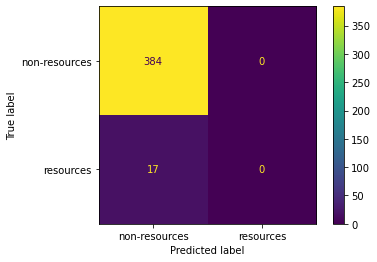

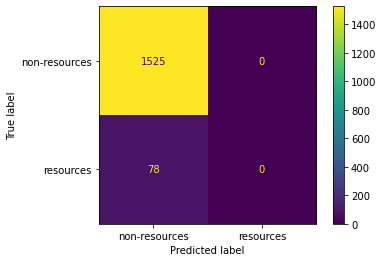

In [82]:
classifier = retrieve_trained_model(CURRENT_METRIC, train_datasets, val_datasets, val_loaders, train_loaders)

In [85]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [86]:
# save model parameters in pytorch
torch.save(model.state_dict(), f'pytorchversion_{CURRENT_METRIC}.pkl')

In [87]:
# inspecting misclassified samples in the validation to guide next improvement steps
for i in range(10):
    text = Xvals[CURRENT_METRIC][y_true_val != y_predict_val].iloc[i]['text']
    label = '?'
    label = Xvals[CURRENT_METRIC][y_true_val != y_predict_val].iloc[i][CURRENT_METRIC]
    print(f'Text: {text}\nLabel: {label}\n')

Text: Pays well Schedule Nice bonus Safety oriented Cares about people. 
Label: 0

Text: Good benefits and good ways for career progression. 
Label: 0

Text: Great people and tons of opportunities. 
Label: 0

Text: Good pay and benefits. Good work life balance.. 
Label: 0

Text: The package
Label: 0

Text: Great team culture. Good compensation. Values work life balance. Flexible schedules. Good benefits.. 
Label: 0

Text: Benefits
Label: 0

Text: High salary
Label: 0

Text: Strong management
Label: 0

Text: Dependable job. Insurance was great until Obama ruined it. Great officers - team players.. 
Label: 0



# Applying the Classifier
*This section only focuses on the text column. For focus on pros and cons individually, see "Automating the Classifier".*

In [162]:
# STEP 5 - FORMAL DEPLOYMENT
# Note: If this is an existing session, do NOT run this cell
#       If this is a new session, please re-run Step 1 and this cell
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
device = torch.device(available_torch_device)

print(f'Metric List: {metrics}')
CURRENT_METRIC = input(f'Which of the {len(metrics)} metrics would you like to focus on currently?: ')

# load the saved weights to the pretrained the model
model.load_state_dict(torch.load(f'pytorchversion_{CURRENT_METRIC}.pkl', map_location = available_torch_device))
model.to(device)

# reload and clean the review dataset
prelim_reviews = pd.read_csv("all_reviews.csv", header = 0, sep = ";")
reviews = prelim_reviews.drop(["Unnamed: 0"], axis = 1)
reviews = glass_door_review_cleaner(reviews)
reviews["text"] = final_review_cleaner(reviews)

# remove NaN/invalid values
# reviews = reviews.dropna()

# add sentiment analyses
pros_sentiment = retrieve_sentiment_analysis(reviews, "pros")
cons_sentiment = retrieve_sentiment_analysis(reviews, "cons")
combined_sentiment = retrieve_sentiment_analysis(reviews, "text")

reviews["score_pros"] = pros_sentiment["compound"]
reviews["score_cons"] = cons_sentiment["compound"]
reviews["score_combined"] = combined_sentiment["compound"]
reviews.head()

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at C:\Users\Bella/.cache\huggingface\transformers\23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.5",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at C:\Users\Bella/.cache\huggingface\transformers\9c169103d7e5a73936dd2b627e42851bec0831212

Metric List: ['insurance', 'safety', 'balance', 'retirement', 'culture', 'racism', 'sexism', 'ageism', 'benefits', 'opportunities', 'privacy', 'resources']
Which of the 12 metrics would you like to focus on currently?: retirement
Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews


,Company,review_title,pros,cons,text,score_pros,score_cons,score_combined
0,ExxonMobil,Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so fa...,pro great work environment great benefit prett...,0.95,0.87,0.97
1,ExxonMobil,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...,pro outstanding colleague working high impact ...,0.32,0.65,0.77
2,ExxonMobil,Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to joi...,pro flexibility nature working like family env...,0.86,0.93,0.96
3,ExxonMobil,I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w...",pro achieving dream partnership company thankf...,0.77,0.91,0.93
4,ExxonMobil,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...,pro competitive pay structured benefit job sat...,0.7,0.72,0.9


In [163]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

# test case
# input_args = ["i love insurance", "resources", "i hate their insurance"]
# tokenized_dep = tokenizer(input_args, padding = "max_length", truncation = True)
# dep_labels = [0] * len(input_args)

# tokenize input_arguments 
tokenized_dep = tokenizer(reviews["text"].astype(str).values.tolist(), padding = "max_length", truncation = True)

# assumed dep_labels, with the same length of input arguments, if you don't know the exact labels just set them to zeros as example
dep_labels = [0] * len(reviews["text"].astype(str).values.tolist())

# make dep_dataset with input arguments and assumed dep_labels
dep_dataset = MYDataset(tokenized_dep, dep_labels)

loading file https://huggingface.co/distilbert-base-cased/resolve/main/vocab.txt from cache at C:\Users\Bella/.cache\huggingface\transformers\ba377304984dc63e3ede0e23a938bbbf04d5c3835b66d5bb48343aecca188429.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791
loading file https://huggingface.co/distilbert-base-cased/resolve/main/tokenizer.json from cache at C:\Users\Bella/.cache\huggingface\transformers\acb5c2138c1f8c84f074b86dafce3631667fccd6efcb1a7ea1320cf75c386a36.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6
loading file https://huggingface.co/distilbert-base-cased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-cased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-cased/resolve/main/tokenizer_config.json from cache at C:\Users\Bella/.cache\huggingface\transformers\81e970e5e6ec68be12da0f8f3b2f2469c78d579282299a2ea65b4b7441719107.ec5c189f89

In [164]:
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [165]:
# get the y_predict of input tokens, similar to the function "predict_dataset" shown in STEP3
dep_loader = DataLoader(dep_dataset, batch_size = 1, shuffle = False)
y_predict = []
count = 1

for batch in dep_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device)
    outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
    
    predictions = torch.argmax(outputs.logits, dim = 1)
    y_predict_batch = predictions.cpu().detach().numpy()
    for j in y_predict_batch:
        y_predict.append(j)
        
    del input_ids
    del attention_mask
    del labels
    del outputs
    del predictions
    
    if count % 250 == 0:
        print(f'Batch {count} for review loader completed.')
    count += 1

y_predict = np.array(y_predict)

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

In [166]:
# test case
# deployment_dict = {
#     'text': input_args,
#     'prediction': y_predict
# }

deployment_dict = {
    'text': reviews["text"],
    'prediction': y_predict
}

deployment_output = pd.DataFrame(deployment_dict)
deployment_output.head(30)

,text,prediction
0,pro great work environment great benefit prett...,0
1,pro outstanding colleague working high impact ...,0
2,pro flexibility nature working like family env...,0
3,pro achieving dream partnership company thankf...,0
4,pro competitive pay structured benefit job sat...,0
5,pro pension health insurance benefit rotating ...,0
6,pro benefit salary people environment campus c...,0
7,pro overall good place work con reorganization...,0
8,pro people assignment opportunity benefit sala...,0
9,pro great place work depending career path gro...,0


In [167]:
reviews[CURRENT_METRIC] = y_predict
reviews.head()

,Company,review_title,pros,cons,text,score_pros,score_cons,score_combined,retirement
0,ExxonMobil,Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so fa...,pro great work environment great benefit prett...,0.95,0.87,0.97,0
1,ExxonMobil,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...,pro outstanding colleague working high impact ...,0.32,0.65,0.77,0
2,ExxonMobil,Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to joi...,pro flexibility nature working like family env...,0.86,0.93,0.96,0
3,ExxonMobil,I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w...",pro achieving dream partnership company thankf...,0.77,0.91,0.93,0
4,ExxonMobil,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...,pro competitive pay structured benefit job sat...,0.7,0.72,0.9,0


In [ ]:
print(f'Shape of original reviews: {reviews.shape}')
print(f'Shape of reviews predicted with metric: {reviews[reviews[CURRENT_METRIC] == 1].shape}')

In [168]:
reviews.to_csv(f'classified_{CURRENT_METRIC}.csv', sep = ';', encoding = 'utf-8', index = False)

# Automating the Classifier (optional)
*This section focuses on classifying all metrics on the pros and cons columns individually.*

In [129]:
# reload and clean the review dataset
prelim_reviews = pd.read_csv("all_reviews.csv", header = 0, sep = ";")
reviews = prelim_reviews.drop(["Unnamed: 0"], axis = 1)
reviews = glass_door_review_cleaner(reviews)
reviews["text"] = final_review_cleaner(reviews)

# remove NaN/invalid values
# reviews = reviews.dropna()

# add sentiment analyses
pros_sentiment = retrieve_sentiment_analysis(reviews, "pros")
cons_sentiment = retrieve_sentiment_analysis(reviews, "cons")
combined_sentiment = retrieve_sentiment_analysis(reviews, "text")

reviews["score_pros"] = pros_sentiment["compound"]
reviews["score_cons"] = cons_sentiment["compound"]
reviews["score_combined"] = combined_sentiment["compound"]

reviews.head()

Done with 500 reviews
Done with 1000 reviews
Done with 1500 reviews
Done with 2000 reviews
Done with 2500 reviews
Done with 3000 reviews
Done with 3500 reviews
Done with 4000 reviews
Done with 4500 reviews
Done with 5000 reviews
Done with 5500 reviews
Done with 6000 reviews
Done with 6500 reviews
Done with 7000 reviews
Done with 7500 reviews
Done with 8000 reviews
Done with 8500 reviews
Done with 9000 reviews


,Company,date,employee_title,employee_status,review_title,pros,cons,text,score_pros,score_cons,score_combined
0,ExxonMobil,2021-05-18,IT Analyst,"Current Employee, more than 1 year",Great Company Overall,Great work environment Great benefits Pretty g...,I have not experienced anything negative so far,pro great work environment great benefit prett...,0.95,0.46,0.96
1,ExxonMobil,2021-09-04,R&D Manager,Former Employee,working on energy R&D,"Outstanding colleagues, working on high impact...",Difficult industry business environment curren...,pro outstanding colleague working high impact ...,0.32,-0.36,-0.05
2,ExxonMobil,2021-10-16,Chemical Technician,"Current Employee, more than 3 years",Flexibility,The flexibility and the nature of working ther...,No downside. PERIOD. Such a great place to join.,pro flexibility nature working like family env...,0.86,0.79,0.95
3,ExxonMobil,2021-10-15,Anonymous,"Current Employee, more than 10 years",I can only be thankful,I am achieving my dreams in partnership with t...,"It is hard times right now. But for me, it's w...",pro achieving dream partnership company thankf...,0.77,0.28,0.81
4,ExxonMobil,2021-10-13,Engineer,Former Employee,Decent company to work for,"Competitive pay, structured benefits, and job ...",Even if you worked your tail off the whole yea...,pro competitive pay structured benefit job sat...,0.7,-0.2,0.61


In [ ]:
def classify_with_BERT(reviews_df, column, metric)
    """ Classifies the metrics for a given dataset into their own columns.
    
    Args:
        reviews_df::[pd.DataFrame]
            The reviews table to analyze.
        column::[str]
            The column of values within the table to be classified.
        metric::[str]
            The specific metric to base the classification on.
    """

    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
    device = torch.device(available_torch_device)
    
    # load the saved weights to the pretrained the model
    model.load_state_dict(torch.load(f'pytorchversion_{metric}.pkl', map_location = available_torch_device))
    model.to(device)
    
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

    # tokenize input_arguments 
    tokenized_dep = tokenizer(reviews_df[column].astype(str).values.tolist(), padding = "max_length", truncation = True)

    # assumed dep_labels, with the same length of input arguments, if you don't know the exact labels just set them to zeros as example
    dep_labels = [0] * len(reviews_df[column].astype(str).values.tolist())

    # make dep_dataset with input arguments and assumed dep_labels
    dep_dataset = MYDataset(tokenized_dep, dep_labels)
    
    model.eval()
    
    dep_loader = DataLoader(dep_dataset, batch_size = 1, shuffle = False)
    y_predict = []
    count = 1

    for batch in dep_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)

        predictions = torch.argmax(outputs.logits, dim = 1)
        y_predict_batch = predictions.cpu().detach().numpy()
        for j in y_predict_batch:
            y_predict.append(j)

        del input_ids
        del attention_mask
        del labels
        del outputs
        del predictions

        if count % 250 == 0:
            print(f'Batch {count} for review loader completed.')
        count += 1

    y_predict = np.array(y_predict)
    
    deployment_dict = {
        'text': reviews_df["text"],
        'prediction': y_predict
    }

    deployment_output = pd.DataFrame(deployment_dict)
    
    reviews_df[f'{metric}_{column}'] = y_predict

In [14]:
for metric in metrics:
    classify_with_BERT(reviews, 'pros', metric)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Batch 250 for review loader completed.
Batch 500 for review loader completed.
Batch 750 for review loader completed.
Batch 1000 for review loader completed.
Batch 1250 for review loader completed.
Batch 1500 for review loader completed.
Batch 1750 for review loader completed.
Batch 2000 for review loader completed.
Batch 2250 for review loader completed.
Batch 2500 for review loader completed.
Batch 2750 for review loader completed.
Batch 3000 for review loader completed.
Batch 3250 for review loader completed.
Batch 3500 for review loader completed.
Batch 3750 for review loader completed.
Batch 4000 for review loader completed.
Batch 4250 for review loader completed.
Batch 4500 for review loader completed.
Batch 4750 for review loader completed.
Batch 5000 for review loader completed.
Batch 5250 for review loader completed.
Batch 5500 for review loader completed.
Batch 5750 for review loader completed.
Batch 6000 for review loader completed.
Batch 6250 for review loader completed.
Bat

In [121]:
for metric in metrics:
    shape_p = reviews[reviews[f'{metric}_pros'] == 1].shape
    shape_c = reviews[reviews[f'{metric}_cons'] == 1].shape
    print(f'Shape of reviews predicted with {metric}_pros metric: {shape_p}')
    print(f'Shape of reviews predicted with {metric}_cons metric: {shape_c}')

Shape of reviews predicted with insurance_pros metric: (0, 32)
Shape of reviews predicted with insurance_cons metric: (0, 32)
Shape of reviews predicted with safety_pros metric: (0, 32)
Shape of reviews predicted with safety_cons metric: (0, 32)
Shape of reviews predicted with balance_pros metric: (562, 32)
Shape of reviews predicted with balance_cons metric: (0, 32)
Shape of reviews predicted with retirement_pros metric: (0, 32)
Shape of reviews predicted with retirement_cons metric: (0, 32)
Shape of reviews predicted with culture_pros metric: (0, 32)
Shape of reviews predicted with culture_cons metric: (0, 32)
Shape of reviews predicted with racism_pros metric: (0, 32)
Shape of reviews predicted with racism_cons metric: (0, 32)
Shape of reviews predicted with sexism_pros metric: (0, 32)
Shape of reviews predicted with sexism_cons metric: (0, 32)
Shape of reviews predicted with ageism_pros metric: (0, 32)
Shape of reviews predicted with ageism_cons metric: (0, 32)
Shape of reviews pre

In [ ]:
reviews.to_csv('all_reviews_classified_BERT.csv', sep = ';', encoding = 'utf-8', index = False)